In [ ]:
!conda install -y -c anaconda psycopg2 sqlalchemy

In [ ]:
!pip install  xgboost

In [1]:
!pip install ipython-sql

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="22"

In [3]:
#Extra functions helpers to make plots

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [4]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




In [5]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_prod_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

event_id            event_time  \
0  e070d328-383d-47d9-8c20-dfe835acc5c8  2018-03-18T22:55:30Z   
1  ccfc646c-166b-4bb4-9016-658181ba3cee  2017-10-16T08:28:02Z   
2  f724d2ad-ca02-4632-95f9-f70aefc04945  2017-12-02T20:25:14Z   
3  e117a9bf-2e5b-4285-8958-982d23bb9dae  2018-04-01T01:12:29Z   
4  6308ad1c-139d-4a79-b292-0c2c0f36cdfc  2017-12-20T01:21:18Z   

                           request_id  partner_id origin destination  \
0  6FNxIK1o9kgMLx6Qm3PJPzAHYcQM5HCAU8          22    AKL         LAX   
1  zhKAI3AJ5OntEmp2rHSme1ih9wOEClE2C2          22    AKL         NRT   
2  Ema34aeuJS4t1Lya2zcFRFJae1Q1VrBXDV          22    AKL         HNL   
3  WMQBTuUibLUUWAyoaab0ycUhrzx0DR5mAR          22    AKL         IAH   
4  OufIUVNl1EVk5Rc1YcwhB9IZ10ldNEXEnq          22    AKL         SYD   

   flight_number departure_date departure_time currency     ...      \
0              2     2018-03-24          22:50      NZD     ...       
1             99     2018-04-06          08:55      NZD     ...       
2             10     2018-04-14          20:55      NZD     ...       
3             28     2018-04-21          16:00      USD     ...       
4            107     2017-12-31          11:00      AUD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5      725      6523             mi       77W         1460.0   
1           5      655      5496             mi       789         1437.0   
2           5      510      4410             mi       789         1240.0   
3           5      820      7430             mi       789         1463.0   
4           5      215      1343             mi       772          419.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0          253.0            499.0          NaN         NaN  
1          359.0            539.0          NaN         NaN  
2          138.0            275.0          NaN         NaN  
3          253.0            499.0          NaN         NaN  
4           70.0            140.0          NaN         NaN  

[5 rows x 33 columns]

In [6]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260149 entries, 0 to 260148
Data columns (total 33 columns):
event_id                              260149 non-null object
event_time                            260149 non-null object
request_id                            260149 non-null object
partner_id                            260149 non-null int64
origin                                260149 non-null object
destination                           260149 non-null object
flight_number                         260149 non-null int64
departure_date                        260149 non-null object
departure_time                        260149 non-null object
currency                              260149 non-null object
pnr                                   260149 non-null object
language                              260149 non-null object
pax                                   260149 non-null int64
eligibility                           260149 non-null bool
point_of_sale                         26

In [7]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [8]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
260144  2018-03-03T04:14:52Z          22    AKL         IAH             28   
260145  2017-11-04T03:06:00Z          22    AKL         LAX              6   
260146  2017-11-14T19:07:27Z          22    LAX         AKL              5   
260147  2017-10-04T20:56:29Z          22    PVG         AKL            288   
260148  2017-09-23T12:59:44Z          22    PVG         AKL            288   

       departure_date departure_time currency language  pax   ...    \
260144     2018-04-15          16:00      USD       en    2   ...     
260145     2017-11-27          19:30      AUD       en    3   ...     
260146     2018-01-28          21:40      AUD       en    1   ...     
260147     2017-11-28          14:15      GBP       en    2   ...     
260148     2017-10-13          14:15      NZD       en    2   ...     

           upgrade_type duration distance equipment slider_max_usd  \
260144         BUSINESS      820     7430       789         2091.0   
260145  PREMIUM_ECONOMY      725     6523       77W         1395.0   
260146  PREMIUM_ECONOMY      770     6523       77W         1395.0   
260147  PREMIUM_ECONOMY      690     5829       789         1072.0   
260148  PREMIUM_ECONOMY      695     5829       789         1101.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
260144          397.0            658.0      985.0000    4227046.0    True  
260145          242.0            476.0      260.1178    3822124.0    True  
260146          241.0            476.0      244.1443    3857560.0    True  
260147          214.0            286.0      218.3411    3720147.0    True  
260148          220.0            294.0      220.1849    3634323.0    True  

[5 rows x 26 columns]

In [9]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    260149.0  260149.000000  260149.000000  260149.000000  260149.000000   
mean         22.0      73.704539       1.642167     574.918777    4853.571880   
std           0.0      85.503158       0.851122     221.278619    2039.157508   
min          22.0       1.000000       1.000000     170.000000    1247.000000   
25%          22.0       7.000000       1.000000     370.000000    3320.000000   
50%          22.0      29.000000       1.000000     650.000000    5496.000000   
75%          22.0     119.000000       2.000000     765.000000    6523.000000   
max          22.0     297.000000      41.000000     980.000000    8200.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   260149.000000   260149.000000     260149.000000  52030.000000   
mean      1057.263026      192.950840        386.103914    295.297525   
std        463.040252       99.954186        185.374713    234.701235   
min        406.000000       67.000000        134.000000     67.974500   
25%        585.000000      108.000000        242.000000    123.958400   
50%       1162.000000      211.000000        332.000000    239.872400   
75%       1378.000000      252.000000        541.000000    397.596500   
max       2159.000000      471.000000        747.000000   2120.000000   

        customer_id  
count  5.203000e+04  
mean   3.676567e+06  
std    7.054606e+05  
min    1.733296e+06  
25%    3.695879e+06  
50%    3.907545e+06  
75%    4.135691e+06  
max    4.358136e+06

In [10]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 260149  260149      260149         260149   
unique                174799      30          30            520   
top     2018-02-27T13:51:43Z     AKL         AKL     2018-03-09   
freq                       9  115425      117488           1667   

       departure_time currency language point_of_sale channel_source  \
count          260149   260149   260149        260149         260149   
unique            169       10        6            24             16   
top             20:55      NZD       en            NZ           ISIS   
freq            14279   135949   258292        135287         138217   

       carrier_code fare_class from_cabin     upgrade_type equipment  
count        260149     260149     260149           260149    260149  
unique            1         19          2                3         5  
top              NZ          S    ECONOMY  PREMIUM_ECONOMY       77W  
freq         260149      48039     219646           146347     99788

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260149 entries, 0 to 260148
Data columns (total 26 columns):
event_time          260149 non-null object
partner_id          260149 non-null int64
origin              260149 non-null object
destination         260149 non-null object
flight_number       260149 non-null int64
departure_date      260149 non-null object
departure_time      260149 non-null object
currency            260149 non-null object
language            260149 non-null object
pax                 260149 non-null int64
eligibility         260149 non-null bool
point_of_sale       260149 non-null object
channel_source      260149 non-null object
carrier_code        260149 non-null object
fare_class          260149 non-null object
from_cabin          260149 non-null object
upgrade_type        260149 non-null object
duration            260149 non-null int64
distance            260149 non-null int64
equipment           260149 non-null object
slider_max_usd      260149 non-null 

## Some visual analysis

In [12]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

In [13]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

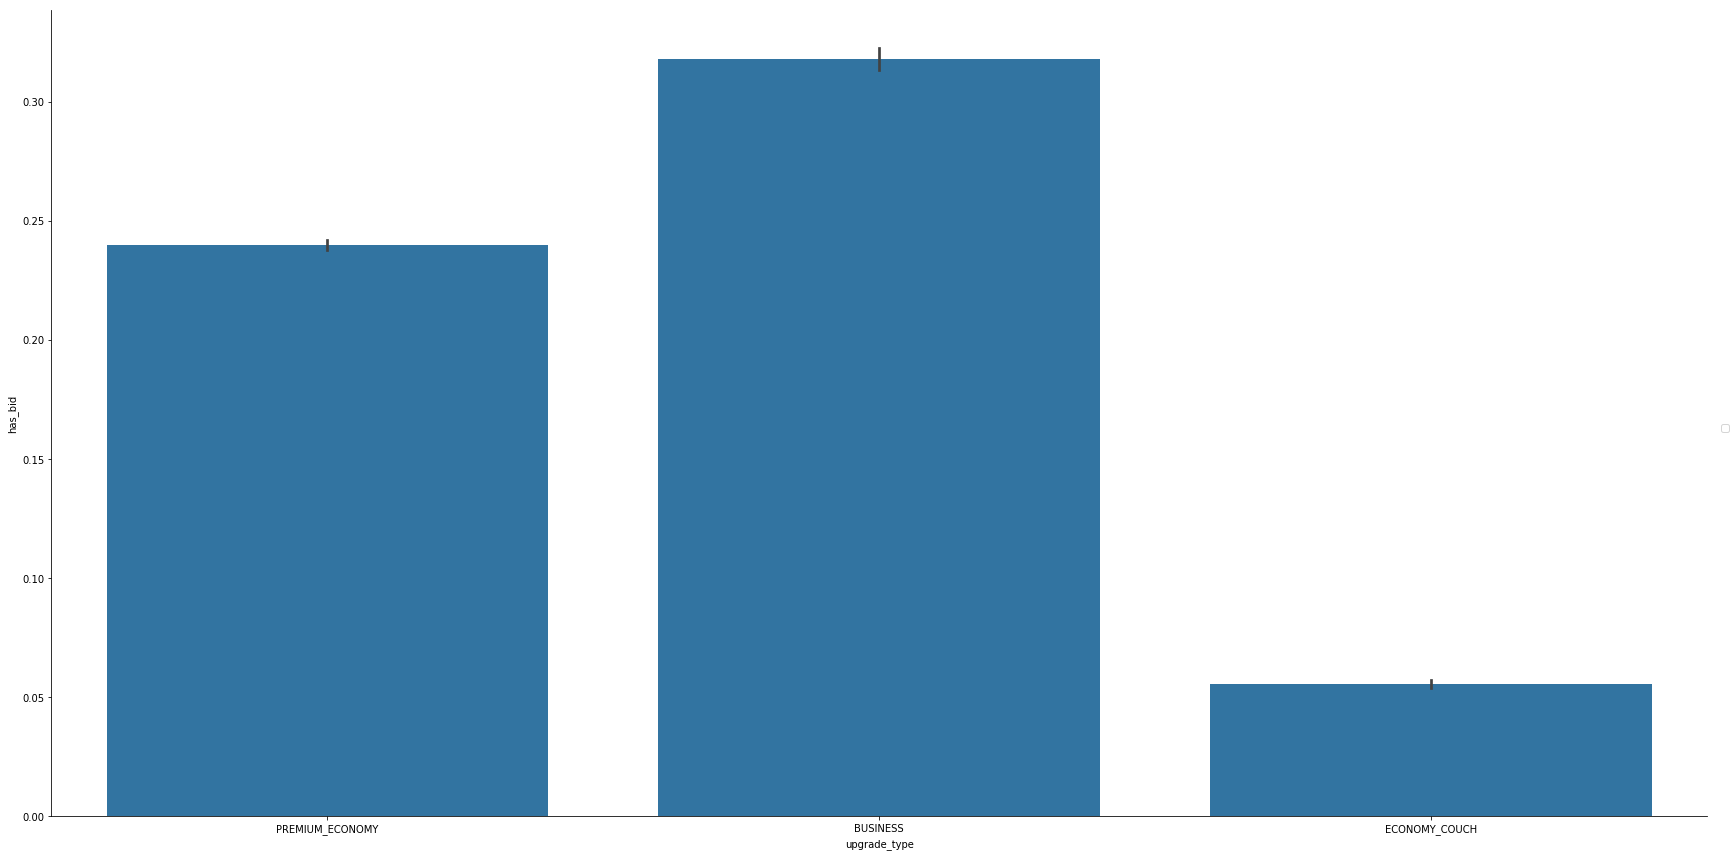

In [14]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

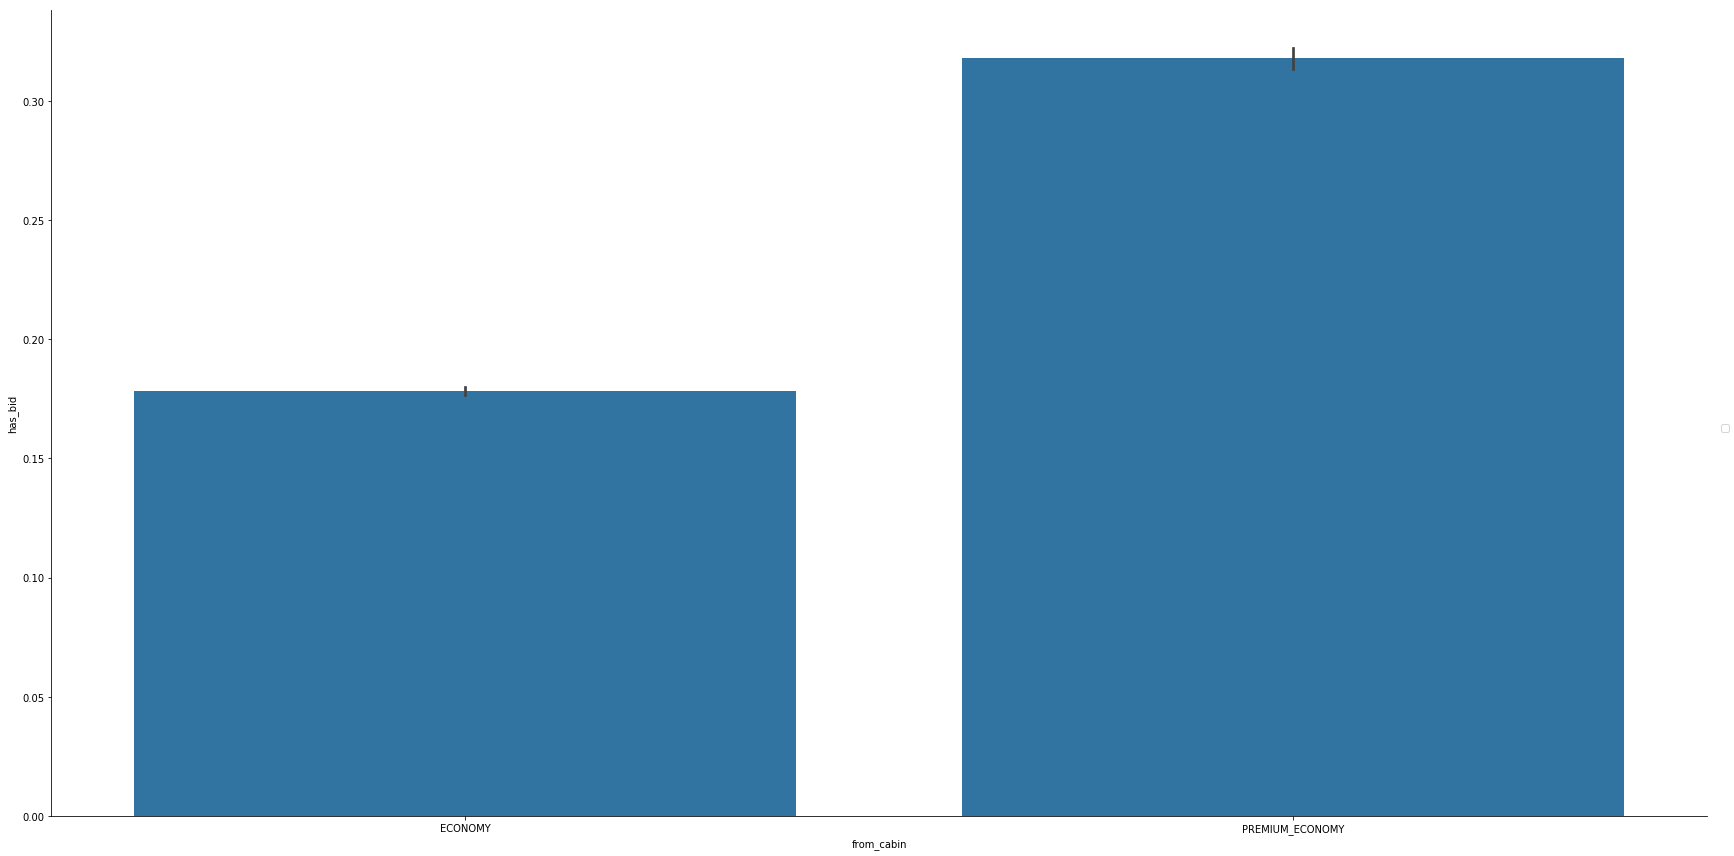

In [15]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

In [16]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

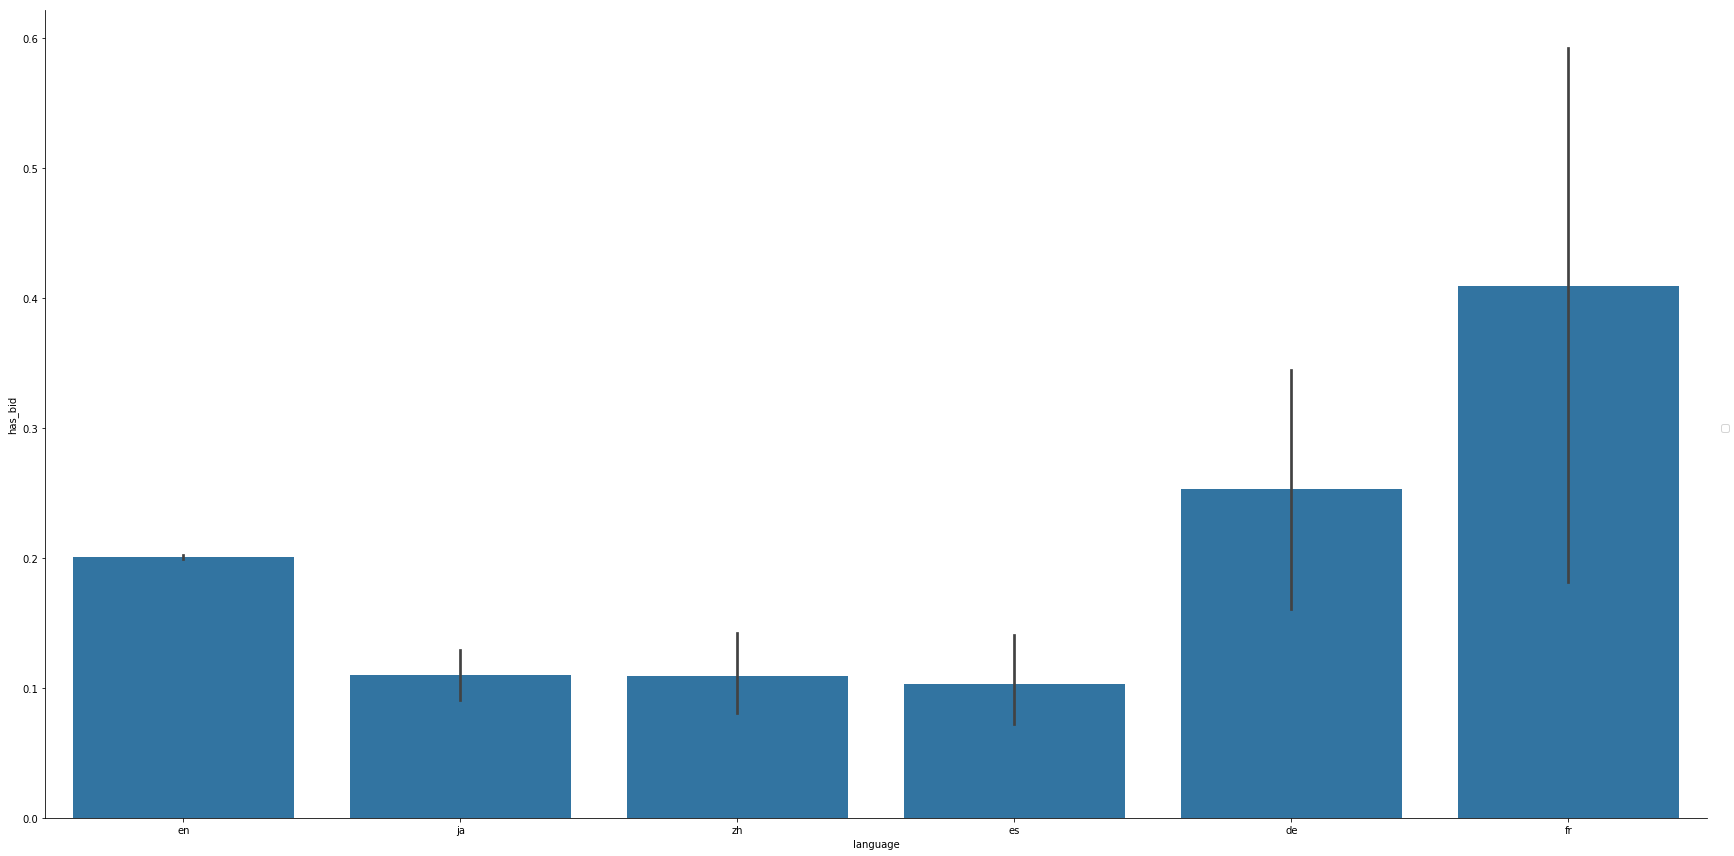

In [17]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [18]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(1)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)


train_df = df_nonNas.drop(['customer_id', 'offer_amount', 'carrier_code', 'partner_id'],axis = 1).copy()


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260149 entries, 0 to 260148
Data columns (total 22 columns):
event_time          260149 non-null object
origin              260149 non-null object
destination         260149 non-null object
flight_number       260149 non-null float32
departure_date      260149 non-null object
departure_time      260149 non-null object
currency            260149 non-null object
language            260149 non-null object
pax                 260149 non-null float32
eligibility         260149 non-null bool
point_of_sale       260149 non-null object
channel_source      260149 non-null object
fare_class          260149 non-null object
from_cabin          260149 non-null object
upgrade_type        260149 non-null object
duration            260149 non-null float32
distance            260149 non-null float32
equipment           260149 non-null object
slider_max_usd      260149 non-null float32
slider_min_usd      260149 non-null float32
slider_start_usd    26014

## Add features

In [20]:
#add days before departure and destination_origin
train_df2 = train_df.copy()

train_df2["event_time"] = train_df2["event_time"].astype('datetime64[ns]')
train_df2["event_time"] = train_df2["event_time"].apply(lambda x: x.date() )
train_df2["departure_date"] = train_df2["departure_date"].astype('datetime64[ns]')
train_df2["departure_date"] = train_df2["departure_date"].apply(lambda x: x.date() )
train_df2["days_before_departure"] = train_df2["departure_date"] - train_df2["event_time"]
train_df2["days_before_departure"] = train_df2["days_before_departure"].apply(lambda x: x.days)
train_df2["destination_origin"] = train_df2["destination"]  + "-" + train_df2["origin"]

train_df2.drop(['event_time', 'departure_date', 'departure_time', 'eligibility'], axis=1, inplace=True)


In [21]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260149 entries, 0 to 260148
Data columns (total 20 columns):
origin                   260149 non-null object
destination              260149 non-null object
flight_number            260149 non-null float32
currency                 260149 non-null object
language                 260149 non-null object
pax                      260149 non-null float32
point_of_sale            260149 non-null object
channel_source           260149 non-null object
fare_class               260149 non-null object
from_cabin               260149 non-null object
upgrade_type             260149 non-null object
duration                 260149 non-null float32
distance                 260149 non-null float32
equipment                260149 non-null object
slider_max_usd           260149 non-null float32
slider_min_usd           260149 non-null float32
slider_start_usd         260149 non-null float32
has_bid                  260149 non-null bool
days_before_departur

### Factorize categorical features

In [22]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [23]:
#factorize the categorical fields
columns_cat = ["origin", "destination", "flight_number", "currency", "language", "point_of_sale", "fare_class", "from_cabin", "upgrade_type", "equipment", "destination_origin"]  
train_df_fact = factorize_df(train_df2, columns_cat) 

In [24]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260149 entries, 0 to 260148
Data columns (total 20 columns):
origin                   260149 non-null int64
destination              260149 non-null int64
flight_number            260149 non-null int64
currency                 260149 non-null int64
language                 260149 non-null int64
pax                      260149 non-null float32
point_of_sale            260149 non-null int64
channel_source           260149 non-null int64
fare_class               260149 non-null int64
from_cabin               260149 non-null int64
upgrade_type             260149 non-null int64
duration                 260149 non-null float32
distance                 260149 non-null float32
equipment                260149 non-null int64
slider_max_usd           260149 non-null float32
slider_min_usd           260149 non-null float32
slider_start_usd         260149 non-null float32
has_bid                  260149 non-null bool
days_before_departure    260149 

## Create a models and evaluations

In [25]:
#Function utils

random_forest = RandomForestClassifier(n_estimators=100)
from xgboost import XGBClassifier
boost = XGBClassifier()

def do_train(df_to_train, n_splits = 2, model = boost):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    accuracys = []
    aucs = []
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        #print( "\nFold ", i+1)
        model.fit(X_train, y_train)
        acc_random_forest = round(model.score(X_valid, y_valid) * 100, 2)
        accuracys.append(acc_random_forest)
        Y_test_pred = model.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        aucs.append(metrics.auc(fpr, tpr))
    print ("ACCURACY = {}".format(reduce(lambda x, y: x + y, accuracys) / len(accuracys)))  
    print ("AUC = {}".format(reduce(lambda x, y: x + y, aucs) / len(aucs)))  


In [26]:
do_train(train_df_fact)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7504297241311724


### We already know the channel_source is a very important feature. Lets, try to figure out which of the features have more impact, training the model without them 

In [27]:
from itertools import combinations 
def combs(x):
    return [c for i in range(len(x)+1) for c in combinations(x,i)]

In [28]:
features = list(train_df_fact.drop(["has_bid", "channel_source"], axis = 1).columns.values)
featureCombinations = combs(features)
featureCombinations = list(map(lambda x: list(x), list(filter(lambda x: len(x) < 3 and len(x) > 0, featureCombinations))))

In [29]:
for featureSet in featureCombinations:
    print ("Feature removed {}".format(featureSet))
    do_train(train_df_fact.drop(featureSet,axis=1))

Feature removed ['origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7506304873908239
Feature removed ['destination']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7504297241311724
Feature removed ['flight_number']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7510999976526518
Feature removed ['currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7509405080934501
Feature removed ['language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7504329046886806
Feature removed ['pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7476419039210864
Feature removed ['point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7508018554624053
Feature removed ['fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7495769437044391
Feature removed ['from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7504297241311724
Feature removed ['upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66
AUC = 0.744786831197563
Feature removed ['duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.750621171900498
Feature removed ['distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7503896264142351
Feature removed ['equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.750554012181716
Feature removed ['slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7514484222986519
Feature removed ['slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7502580643700141
Feature removed ['slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.751157292715424
Feature removed ['days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.575
AUC = 0.7405204587360604
Feature removed ['destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67
AUC = 0.7510323751595884
Feature removed ['origin', 'destination']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7506304873908239
Feature removed ['origin', 'flight_number']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7508549860036717
Feature removed ['origin', 'currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.655
AUC = 0.750319455364041
Feature removed ['origin', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7505130151346266
Feature removed ['origin', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.7478006993625264
Feature removed ['origin', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7504270988323264
Feature removed ['origin', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7499339250158461
Feature removed ['origin', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7506304873908239
Feature removed ['origin', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66
AUC = 0.7444254739442564
Feature removed ['origin', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7506093566999219
Feature removed ['origin', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7498514909707689
Feature removed ['origin', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7506473401995708
Feature removed ['origin', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7511136506064834
Feature removed ['origin', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7502206088313311
Feature removed ['origin', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.705
AUC = 0.7515291214512918
Feature removed ['origin', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.565
AUC = 0.740627726806246
Feature removed ['origin', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66499999999999
AUC = 0.7506327287647159
Feature removed ['destination', 'flight_number']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7510999976526518
Feature removed ['destination', 'currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7509405080934501
Feature removed ['destination', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7504329046886806
Feature removed ['destination', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7476419039210864
Feature removed ['destination', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7508018554624053
Feature removed ['destination', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7495769437044391
Feature removed ['destination', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7504297241311724
Feature removed ['destination', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66
AUC = 0.744786831197563
Feature removed ['destination', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.750621171900498
Feature removed ['destination', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7503896264142351
Feature removed ['destination', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.750554012181716
Feature removed ['destination', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7514484222986519
Feature removed ['destination', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7502580643700141
Feature removed ['destination', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.751157292715424
Feature removed ['destination', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.575
AUC = 0.7405204587360604
Feature removed ['destination', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.750748355558041
Feature removed ['flight_number', 'currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7510063080625193
Feature removed ['flight_number', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7510394400608897
Feature removed ['flight_number', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.747730710031331
Feature removed ['flight_number', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7501255971364178
Feature removed ['flight_number', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7498147275926332
Feature removed ['flight_number', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7510999976526518
Feature removed ['flight_number', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.65
AUC = 0.7447411493596632
Feature removed ['flight_number', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7509129144632813
Feature removed ['flight_number', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7501189022300332
Feature removed ['flight_number', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.7510340321875673
Feature removed ['flight_number', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.7512662165869024
Feature removed ['flight_number', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7511872671848951
Feature removed ['flight_number', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.71000000000001
AUC = 0.7518036581379629
Feature removed ['flight_number', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.58500000000001
AUC = 0.7410270883701204
Feature removed ['flight_number', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7504105560909808
Feature removed ['currency', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7508375996538577
Feature removed ['currency', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67500000000001
AUC = 0.7474237083713404
Feature removed ['currency', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.55
AUC = 0.7411529614736354
Feature removed ['currency', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7497937615096156
Feature removed ['currency', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7509405080934501
Feature removed ['currency', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66499999999999
AUC = 0.7449131391921113
Feature removed ['currency', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7510114076894087
Feature removed ['currency', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.705
AUC = 0.7506152450534902
Feature removed ['currency', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7509681654768015
Feature removed ['currency', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.7
AUC = 0.7513581469619779
Feature removed ['currency', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67
AUC = 0.7506937665465192
Feature removed ['currency', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.7
AUC = 0.7513485063082321
Feature removed ['currency', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.575
AUC = 0.7406761605268106
Feature removed ['currency', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7509553452458648
Feature removed ['language', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7477781359110705
Feature removed ['language', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.705
AUC = 0.7508584572559942
Feature removed ['language', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.749432822768491
Feature removed ['language', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7504329046886806
Feature removed ['language', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.655
AUC = 0.7446099210564505
Feature removed ['language', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7507106739505492
Feature removed ['language', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7506347480792864
Feature removed ['language', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7504720812717326
Feature removed ['language', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7514080703954309
Feature removed ['language', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67500000000001
AUC = 0.7503499946705273
Feature removed ['language', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.705
AUC = 0.7512331570878774
Feature removed ['language', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.575
AUC = 0.7403232674925347
Feature removed ['language', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7508518588590969
Feature removed ['pax', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7476537983944598
Feature removed ['pax', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7470754136234301
Feature removed ['pax', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7476419039210864
Feature removed ['pax', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.7427607493695255
Feature removed ['pax', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66999999999999
AUC = 0.7476218760030474
Feature removed ['pax', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.7475192126908324
Feature removed ['pax', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7476419039210864
Feature removed ['pax', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.7
AUC = 0.7478475474506723
Feature removed ['pax', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7479128309903946
Feature removed ['pax', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7481661499438746
Feature removed ['pax', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.55000000000001
AUC = 0.7343472833528774
Feature removed ['pax', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7476856380583247
Feature removed ['point_of_sale', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.7498138777570422
Feature removed ['point_of_sale', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7508018554624053
Feature removed ['point_of_sale', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.7448886459898845
Feature removed ['point_of_sale', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.750084752689909
Feature removed ['point_of_sale', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7507054874466556
Feature removed ['point_of_sale', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7510111506697229
Feature removed ['point_of_sale', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.705
AUC = 0.75122024557686
Feature removed ['point_of_sale', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67
AUC = 0.7504475857726698
Feature removed ['point_of_sale', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.7
AUC = 0.7513244235746372
Feature removed ['point_of_sale', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.57499999999999
AUC = 0.7409867921242506
Feature removed ['point_of_sale', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.750735297534088
Feature removed ['fare_class', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7495769437044391
Feature removed ['fare_class', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.665
AUC = 0.7438629188030348
Feature removed ['fare_class', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7503418917888385
Feature removed ['fare_class', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67500000000001
AUC = 0.7498158444408253
Feature removed ['fare_class', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7494585151536076
Feature removed ['fare_class', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.71
AUC = 0.7505868486985328
Feature removed ['fare_class', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7501618142252016
Feature removed ['fare_class', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7505700086897662
Feature removed ['fare_class', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.56
AUC = 0.7384821843143228
Feature removed ['fare_class', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7495997490400467
Feature removed ['from_cabin', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.615
AUC = 0.7436977728999499
Feature removed ['from_cabin', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.750621171900498
Feature removed ['from_cabin', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7503896264142351
Feature removed ['from_cabin', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.750554012181716
Feature removed ['from_cabin', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7514484222986519
Feature removed ['from_cabin', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7502580643700141
Feature removed ['from_cabin', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.751157292715424
Feature removed ['from_cabin', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.575
AUC = 0.7405204587360604
Feature removed ['from_cabin', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67
AUC = 0.7510323751595884
Feature removed ['upgrade_type', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66
AUC = 0.744886987911013
Feature removed ['upgrade_type', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67
AUC = 0.7449478228779685
Feature removed ['upgrade_type', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66
AUC = 0.7447913882782741
Feature removed ['upgrade_type', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66499999999999
AUC = 0.7423569629726132
Feature removed ['upgrade_type', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.7447283429314945
Feature removed ['upgrade_type', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.675
AUC = 0.7382710054566981
Feature removed ['upgrade_type', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.58000000000001
AUC = 0.735426452896101
Feature removed ['upgrade_type', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.64500000000001
AUC = 0.7444400629405615
Feature removed ['duration', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7515060321221605
Feature removed ['duration', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7506061047399983
Feature removed ['duration', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.7514700902132606
Feature removed ['duration', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7506552582700827
Feature removed ['duration', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7514214092227927
Feature removed ['duration', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.595
AUC = 0.7410430603317628
Feature removed ['duration', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7512359891774214
Feature removed ['distance', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7504453758130132
Feature removed ['distance', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.705
AUC = 0.7517175907100417
Feature removed ['distance', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7505100322514469
Feature removed ['distance', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7515262045207829
Feature removed ['distance', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.58000000000001
AUC = 0.7410537978017087
Feature removed ['distance', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.750146597170906
Feature removed ['equipment', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7516123612864931
Feature removed ['equipment', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7502580643700141
Feature removed ['equipment', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.7511602779837714
Feature removed ['equipment', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.58500000000001
AUC = 0.7406914445869797
Feature removed ['equipment', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.67
AUC = 0.7509040055686156
Feature removed ['slider_max_usd', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7503565388599117
Feature removed ['slider_max_usd', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.725
AUC = 0.7521907388764486
Feature removed ['slider_max_usd', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.575
AUC = 0.7411965353989967
Feature removed ['slider_max_usd', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7511777148106767
Feature removed ['slider_min_usd', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7509965260785308
Feature removed ['slider_min_usd', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.575
AUC = 0.7405419594634609
Feature removed ['slider_min_usd', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.66999999999999
AUC = 0.7501443054980241
Feature removed ['slider_start_usd', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.58
AUC = 0.741635040226809
Feature removed ['slider_start_usd', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.751482839437746
Feature removed ['days_before_departure', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.58500000000001
AUC = 0.7401587656806949


Some conclusions about the previous results:


And we could try to remove: 


destination

slider_max_usd

duration




    

In [30]:
train_df_fact2 = train_df_fact.drop(['slider_max_usd', 'destination', 'duration' ], axis = 1).copy()
do_train(train_df_fact2)



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.7514700902132606


In [31]:
train_df_fact2 = train_df_fact.drop(['slider_max_usd','duration' ], axis = 1).copy()
do_train(train_df_fact2)



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69999999999999
AUC = 0.7514700902132606


In [32]:
train_df_fact2 = train_df_fact.drop(['slider_max_usd' ], axis = 1).copy()
do_train(train_df_fact2)



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.695
AUC = 0.7514484222986519


#### we could remove  slider max, but the gain is not worth

In [33]:
train_df_fact2 = train_df_fact.copy()
do_train(train_df_fact2)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7504297241311724


In [34]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260149 entries, 0 to 260148
Data columns (total 20 columns):
origin                   260149 non-null int64
destination              260149 non-null int64
flight_number            260149 non-null int64
currency                 260149 non-null int64
language                 260149 non-null int64
pax                      260149 non-null float32
point_of_sale            260149 non-null int64
channel_source           260149 non-null int64
fare_class               260149 non-null int64
from_cabin               260149 non-null int64
upgrade_type             260149 non-null int64
duration                 260149 non-null float32
distance                 260149 non-null float32
equipment                260149 non-null int64
slider_max_usd           260149 non-null float32
slider_min_usd           260149 non-null float32
slider_start_usd         260149 non-null float32
has_bid                  260149 non-null bool
days_before_departure    260149 

### It seems that our dataset reached the minimal set of features for the current feature set

# Feature Engineering v5

### Try to remove flight_number and kept origin and destination

In [35]:
do_train(train_df_fact.drop(['flight_number' , 'destination_origin'], axis = 1))


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7504105560909808


In [36]:
do_train(train_df_fact.drop(['flight_number' , 'destination_origin', 'origin', 'destination'], axis = 1))


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7505255048306863


In [37]:
do_train(train_df_fact.drop(['destination_origin', 'origin', 'destination'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7505267393241988


### Try to create buckets for duration

0 - 60 minutes (Ultra Short Haul)

61 - 150 minutes (Short Haul)

151 - 360 minutes (Medium Haul)

361 - 780 minutes (Long Haul)

780+ minutes (Ultra Long Haul)

In [38]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260149 entries, 0 to 260148
Data columns (total 20 columns):
origin                   260149 non-null int64
destination              260149 non-null int64
flight_number            260149 non-null int64
currency                 260149 non-null int64
language                 260149 non-null int64
pax                      260149 non-null float32
point_of_sale            260149 non-null int64
channel_source           260149 non-null int64
fare_class               260149 non-null int64
from_cabin               260149 non-null int64
upgrade_type             260149 non-null int64
duration                 260149 non-null float32
distance                 260149 non-null float32
equipment                260149 non-null int64
slider_max_usd           260149 non-null float32
slider_min_usd           260149 non-null float32
slider_start_usd         260149 non-null float32
has_bid                  260149 non-null bool
days_before_departure    260149 

In [39]:
train_df_fact3 = train_df_fact2.copy()
#train_df_fact3[ 'ultra_short_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s <= 60 else False )
#train_df_fact3[ 'short_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 60 and s <= 150 else False )
#train_df_fact3[ 'medium_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 150 and s <= 360 else False )
#train_df_fact3[ 'long_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 360 and s <= 780 else False )
#train_df_fact3[ 'ultra_long_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 780 else False )
train_df_fact3[ 'haul' ] = train_df_fact3[ 'duration' ].map( lambda s : 
                                                            1 if s <= 60 else ( 2 if s <= 150 else ( 3 if s <= 360 else( 4 if s<= 780 else 5))))


In [40]:
do_train(train_df_fact3)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7504297241311724


In [41]:
do_train(train_df_fact3.drop(['duration'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.685
AUC = 0.7508365950427349


In [42]:
do_train(train_df_fact3.drop(['duration', 'distance'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.68
AUC = 0.7512265138029854


In [43]:
do_train(train_df_fact3.drop(['duration', 'flight_number'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.69
AUC = 0.7511025663155579


#### It seems that adding the haul to the model stays the same

### Some tests with hyperparameters

In [44]:
from scipy import stats

params ={'n_estimators': [150, 300, 500, 1000],
              'learning_rate': [0.03, 0.06, 0.09, 0.12],
              'subsample': [0.3, 0.5, 0.7, 0.9],
              'max_depth': [3, 5, 7, 9]
}

In [45]:
for i in params['n_estimators']:
    print ("n_estimators {}".format(i))
    boost_tuned = XGBClassifier(    
                        n_estimators=i,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=0.07, 
                        subsample=.8,
                        min_child_weight=.77,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
    do_train(train_df_fact3, model=boost_tuned)

n_estimators 150


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.80000000000001
AUC = 0.7562195379984726
n_estimators 300


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.695
AUC = 0.7586160973805716
n_estimators 500


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.68
AUC = 0.7595721185628692
n_estimators 1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.67500000000001
AUC = 0.7603614365716622


In [ ]:
for i in params['learning_rate']:
    print ("learning_rate {}".format(i))
    boost_tuned = XGBClassifier(    
                        n_estimators=1000,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=i, 
                        subsample=.8,
                        min_child_weight=.77,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
    do_train(train_df_fact3, model=boost_tuned)

learning_rate 0.03


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.74000000000001
AUC = 0.7595508204168405
learning_rate 0.06


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.695
AUC = 0.7604991027934948
learning_rate 0.09


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.7
AUC = 0.7605768460682338
learning_rate 0.12


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.685
AUC = 0.7606578538496409


In [ ]:
for i in params['max_depth']:
    print ("max_depth {}".format(i))
    boost_tuned = XGBClassifier(    
                        n_estimators=1000,
                        max_depth=i,
                        objective="binary:logistic",
                        learning_rate=0.12, 
                        subsample=.8,
                        min_child_weight=.77,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
    do_train(train_df_fact3, model=boost_tuned)

max_depth 3


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.595
AUC = 0.7592538586092584
max_depth 5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 79.65
AUC = 0.761448902448284
max_depth 7


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
